# LAB 6

In [15]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [9]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1- Population Growth Rate

In [10]:
q1_sql = """
SELECT
    n.name AS state,
    p.year,
    p.pop AS population,
    -- Calculate absolute population change from previous year
    p.pop - LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year) AS yoy_abs_change,
    -- Calculate percent growth rate from previous year
    ROUND(
        100.0 * (p.pop - LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year))
        / NULLIF(LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year), 0),
        2
    ) AS yoy_growth_pct
FROM population p
JOIN name n ON n.fips = p.fips
WHERE n.name ILIKE 'Missouri'
ORDER BY p.year;
"""

In [11]:
import pandas as pd

q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head() #show the top 5 rows

/tmp/ipykernel_29413/2656640038.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(q1_sql, con=conn)


,state,year,population,yoy_abs_change,yoy_growth_pct
0,Missouri,2005,5631910,NaN,NaN
1,Missouri,2006,5842713,210803.0,3.74
2,Missouri,2007,5878415,35702.0,0.61
3,Missouri,2008,5911605,33190.0,0.56
4,Missouri,2009,5987580,75975.0,1.29


<Axes: xlabel='year'>

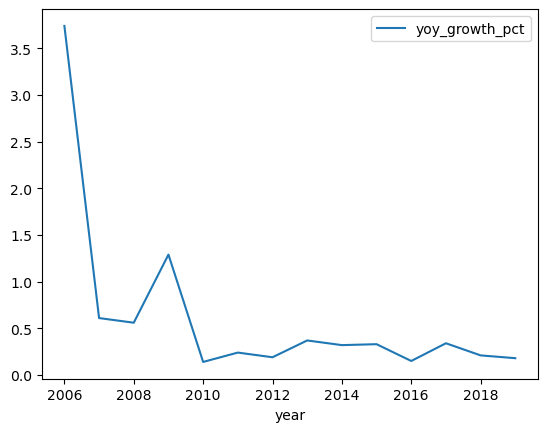

In [12]:
q1_df.plot(x='year', y='yoy_growth_pct')

In [20]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 81.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
! pip install jupyter-ai-magics[all] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.12.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.


In [23]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [24]:
%load_ext jupyter_ai_magics

In [16]:
%%ai gpt4
What is included in the {q1_df}

The provided data represents the population change in Missouri from 2005 to 2019. The columns include:

- **State**: The name of the state, in this case, Missouri.
- **Year**: The specific year in which the population data was recorded.
- **Population**: The total population of Missouri in the given year.
- **yoy_abs_change**: The absolute change in population from the previous year. For instance, in 2006, Missouri's population increased by 210,803 people from the previous year (2005). This data is not available for the year 2005 since there's no prior year for comparison in this dataset.
- **yoy_growth_pct**: The year-on-year growth rate represented as a percentage. This is the percentage change in population compared to the previous year. For example, in 2006, there was a 3.74% increase in the population from 2005. Just like "yoy_abs_change", this data is not available for 2005.

In [17]:
%%ai gpt4 -f code
Use the data in {q1_df}, create a line chart with the growth rate. Chart must include the MO state name in the title

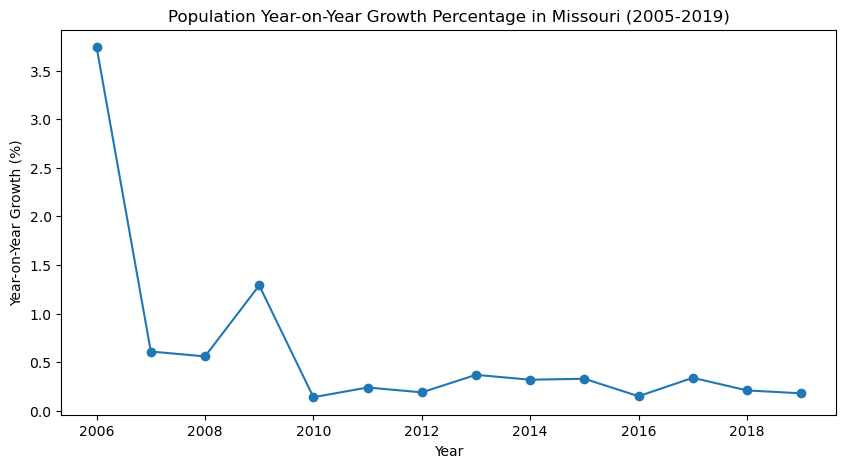

In [18]:
import matplotlib.pyplot as plt

# Define data
years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
growth_rate = [None, 3.74, 0.61, 0.56, 1.29, 0.14, 0.24, 0.19, 0.37, 0.32, 0.33, 0.15, 0.34, 0.21, 0.18]

# Create figure and plot line
plt.figure(figsize=(10,5))
plt.plot(years, growth_rate, marker = 'o')

# Set title and labels
plt.title('Population Year-on-Year Growth Percentage in Missouri (2005-2019)')
plt.xlabel('Year')
plt.ylabel('Year-on-Year Growth (%)')

# Show plot
plt.show()


pop growth rate dropped in 2007, 2009, and 2015. The population increased in 2008, 2012, and 2016, but remained relativley stable after 2010.  

## Q2- Income and Population Relationship

In [19]:
q2_sql = """
SELECT
    n.name AS state,
    i.year,
    i.income,
    p.pop AS population
FROM income i
JOIN population p 
    ON i.fips = p.fips
   AND i.year = p.year
JOIN name n 
    ON n.fips = i.fips
WHERE n.name ILIKE 'Missouri'
ORDER BY i.year;
"""

In [22]:
import pandas as pd

q2_df = pd.read_sql(q2_sql, con=conn)
q2_df.head() #show the top 5 rows

/tmp/ipykernel_29413/3338859629.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql(q2_sql, con=conn)


,state,year,income,population
0,Missouri,2005,41974,5631910
1,Missouri,2006,42841,5842713
2,Missouri,2007,45114,5878415
3,Missouri,2008,46867,5911605
4,Missouri,2009,45229,5987580


In [23]:
%%ai gpt4
What is included in the {q2_df}

The provided data represents the income and population of Missouri from 2005 to 2019. The columns include:

- **State**: The name of the state, in this case, Missouri.
- **Year**: The specific year in which the income and population data was recorded.
- **Income**: The average income (presumably in US dollars, though the dataset doesn't specify) of people in Missouri for the given year. For example, in 2005, the average income in Missouri was 41,974.
- **Population**: The total population of Missouri in the given year. For instance, in 2005, Missouri's population was 5,631,910.

In [24]:
%%ai gpt4 -f code
Use the data in {q2_df}, create a dual axis chart with the X-axis as year, the left y-axis as population (line), and the right y-axis as median household income. Chart must include the MO state name in the title

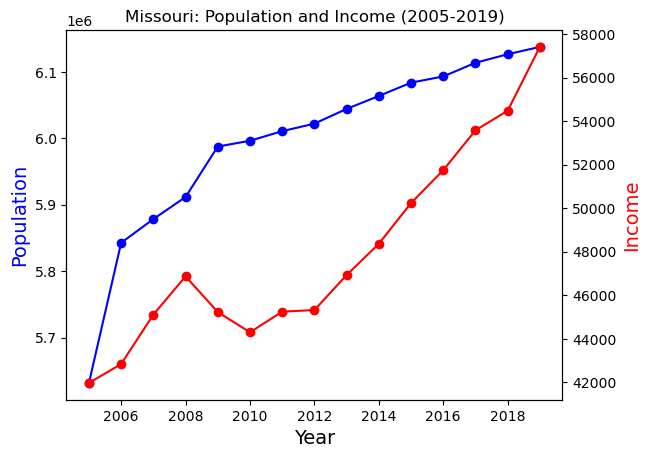

In [25]:
import matplotlib.pyplot as plt

# Define Data
years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
income = [41974, 42841, 45114, 46867, 45229, 44301, 45247, 45321, 46931, 48363, 50238, 51746, 53578, 54478, 57409]
population = [5631910, 5842713, 5878415, 5911605, 5987580, 5996231, 6010688, 6021988, 6044171, 6063589, 6083672, 6093000, 6113532, 6126452, 6137428]

# Create figure and axis objects with subplots()
fig,ax = plt.subplots()

# Make a plot
ax.plot(years, population, color="blue", marker="o")
# Set x-axis label
ax.set_xlabel("Year",fontsize=14)
# Set y-axis label
ax.set_ylabel("Population",color="blue",fontsize=14)

# Twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# Make a plot with different y-axis using second axis object
ax2.plot(years, income, color="red",marker="o")
ax2.set_ylabel("Income",color="red",fontsize=14)


plt.title('Missouri: Population and Income (2005-2019)')
plt.show()

The population and income move inversely to the population from 2008 to 2010. After 2010, the population and income move in the same direction, eventually overlapping in 2019. 

## Q3- Student Question- Population change

In [4]:
q3_sql = """
-- Yearly population and absolute year-over-year change for Missouri (FIPS = 29)
SELECT
    n.name AS state,
    p.year,
    p.fips,
    p.pop AS population,
    -- Absolute change from previous year
    p.pop - LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year) AS yoy_change
FROM population p
JOIN name n
    ON n.fips = p.fips
WHERE p.fips = '29'
  AND p.year BETWEEN 2005 AND 2019
ORDER BY p.year;
"""

In [10]:
import pandas as pd

q3_df = pd.read_sql(q3_sql, con=conn)
q3_df.head() #show the top 5 rows

/tmp/ipykernel_8061/2998452085.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q3_df = pd.read_sql(q3_sql, con=conn)


,state,year,fips,population,yoy_change
0,Missouri,2005,29,5631910,NaN
1,Missouri,2006,29,5842713,210803.0
2,Missouri,2007,29,5878415,35702.0
3,Missouri,2008,29,5911605,33190.0
4,Missouri,2009,29,5987580,75975.0


In [26]:
%%ai gpt4
What is included in the {q3_df}

The output includes the following information on the population of Missouri from 2005 to 2019:

- **State**: The US state in question, which is "Missouri" in all entries
- **Year**: The year for each corresponding data entry, ranging from 2005 to 2019
- **FIPS**: The Federal Information Processing Standards (FIPS) code for Missouri, which is 29 in all entries. FIPS codes are numbers which uniquely identify geographic areas
- **Population**: The population of Missouri for each corresponding year
- **YOY_Change**: The year-on-year population change in Missouri, calculated as the difference between the population in the current year and the previous year. The first entry, for 2005, is NaN (Not a Number) because there's no previous year's data to calculate a change 

The data shows that the population of Missouri has consistently increased each year from 2005 to 2019. For example, in 2006, the population increased by 210,803 from the 2005 population. The rate of increase each year, however, varies.

In [27]:
%%ai gpt4 -f code
Use the data in {q3_df}, create a dual axis chart with the X-axis as year, the left y-axis as population (line), and the right y-axis as yoy_change. Chart must include the MO state name in the title

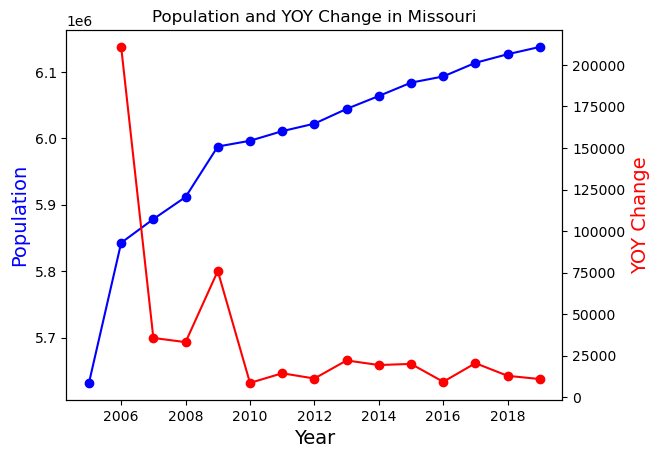

In [28]:
import matplotlib.pyplot as plt

# Store the data in variables
year = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
population = [5631910, 5842713, 5878415, 5911605, 5987580, 5996231, 6010688, 6021988, 6044171, 6063589, 6083672, 6093000, 6113532, 6126452, 6137428]
yoy_change = [None, 210803.0, 35702.0 ,33190.0 ,75975.0 ,8651.0 ,14457.0 ,11300.0 ,22183.0 ,19418.0 ,20083.0 ,9328.0 ,20532.0 ,12920.0 ,10976.0]

# Create figure and axis objects with subplots()
fig,ax = plt.subplots()

# Make a plot with axis = ax for the population 
ax.plot(year, population, color="blue", marker="o")
# Set the x-axis label
ax.set_xlabel("Year",fontsize=14)
# Set the y-axis label
ax.set_ylabel("Population",color="blue",fontsize=14)

# Twin the x-axis for two different y-axis with the same x-axis
ax2=ax.twinx()
# Make a plot with ax2 for the year-on-year change 
ax2.plot(year, yoy_change, color="red",marker="o")
# Set the y-axis label
ax2.set_ylabel("YOY Change",color="red",fontsize=14)

# Set the chart title 
plt.title("Population and YOY Change in Missouri")

plt.show()

As you can see there is a large gain in population from 2006 to 2009 which matched the YOY change. The YOY change dropped sharply after 2009 and reamined relativley stable until 2019.